In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make charts look professional
sns.set_theme(style="whitegrid")

# Load the data we saved in step 16
file_path = '../data/interventional_studies_raw.csv'
print("Loading data...")
df = pd.read_csv(file_path)

print(f"Loaded {len(df)} rows.")

Loading data...
Loaded 1000 rows.


In [4]:
# Convert date columns from String ('2023-01-01') to Datetime objects
# errors='coerce' means: "If you see a weird date like 'Unknown', just turn it into NaT (Not a Time)"
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['completion_date'] = pd.to_datetime(df['completion_date'], errors='coerce')

# Create a new feature: Year
df['start_year'] = df['start_date'].dt.year

# Check if it worked
print(df[['start_date', 'completion_date', 'start_year']].dtypes)
display(df.head(3))

start_date         datetime64[ns]
completion_date    datetime64[ns]
start_year                float64
dtype: object


,nct_id,study_type,start_date,completion_date,overall_status,phase,enrollment,sponsor_name,sponsor_type,condition_name,start_year
0,NCT05391750,INTERVENTIONAL,2022-10-19,2027-02-12,RECRUITING,PHASE1,72.0,Emory University,OTHER,Recurrent Plasma Cell Myeloma,2022.0
1,NCT05391750,INTERVENTIONAL,2022-10-19,2027-02-12,RECRUITING,PHASE1,72.0,Emory University,OTHER,Refractory Plasma Cell Myeloma,2022.0
2,NCT06462118,INTERVENTIONAL,2024-06-17,2024-10-22,COMPLETED,PHASE1,78.0,"Genentech, Inc.",INDUSTRY,Healthy Volunteers,2024.0


In [5]:
# 1. Look at all statuses first
print("--- Original Status Counts ---")
print(df['overall_status'].value_counts())

# 2. Define the filter lists
# These are trials where we know the result
finished_statuses = [
    'COMPLETED', 
    'TERMINATED', 
    'SUSPENDED', 
    'WITHDRAWN'
    # Note: We capitalize because we saw earlier that the data is uppercase
]

# 3. Create the Clean DataFrame
df_clean = df[df['overall_status'].isin(finished_statuses)].copy()

print(f"\n--- Data for Modeling ---")
print(f"Original rows: {len(df)}")
print(f"Rows useful for training (Finished trials): {len(df_clean)}")
print(f"Dropped (Ongoing trials): {len(df) - len(df_clean)}")

--- Original Status Counts ---
overall_status
COMPLETED                  572
UNKNOWN                    169
RECRUITING                  88
TERMINATED                  68
WITHDRAWN                   45
ACTIVE_NOT_RECRUITING       38
NOT_YET_RECRUITING          18
ENROLLING_BY_INVITATION      1
SUSPENDED                    1
Name: count, dtype: int64

--- Data for Modeling ---
Original rows: 1000
Rows useful for training (Finished trials): 686
Dropped (Ongoing trials): 314


--- Target Distribution ---
target
1    572
0    114
Name: count, dtype: int64


C:\Users\NITIN SAVIO BADA\AppData\Local\Temp\ipykernel_11508\2624057534.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='target', palette='coolwarm')


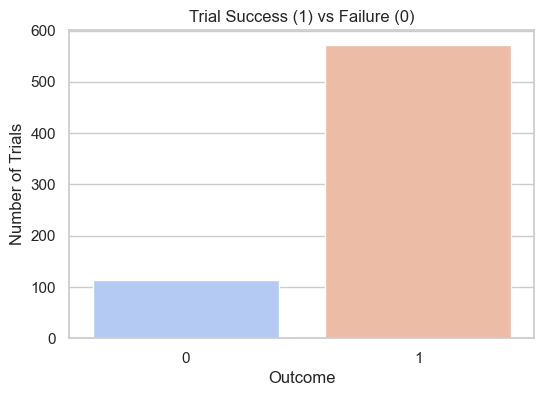

In [6]:
# 1. Create the binary target: 1 if Completed, 0 otherwise
# The apply command checks every row for us
df_clean['target'] = df_clean['overall_status'].apply(lambda x: 1 if x == 'COMPLETED' else 0)

# 2. Count the winners vs losers
print("--- Target Distribution ---")
print(df_clean['target'].value_counts())

# 3. Visualize it nicely
plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x='target', palette='coolwarm')
plt.title("Trial Success (1) vs Failure (0)")
plt.xlabel("Outcome")
plt.ylabel("Number of Trials")
plt.show()

           phase    target  success_rate_pct
0   EARLY_PHASE1  1.000000        100.000000
1         PHASE1  0.877778         87.777778
4  PHASE2/PHASE3  0.875000         87.500000
3         PHASE2  0.825581         82.558140
6         PHASE4  0.775862         77.586207
5         PHASE3  0.732394         73.239437
2  PHASE1/PHASE2  0.586207         58.620690


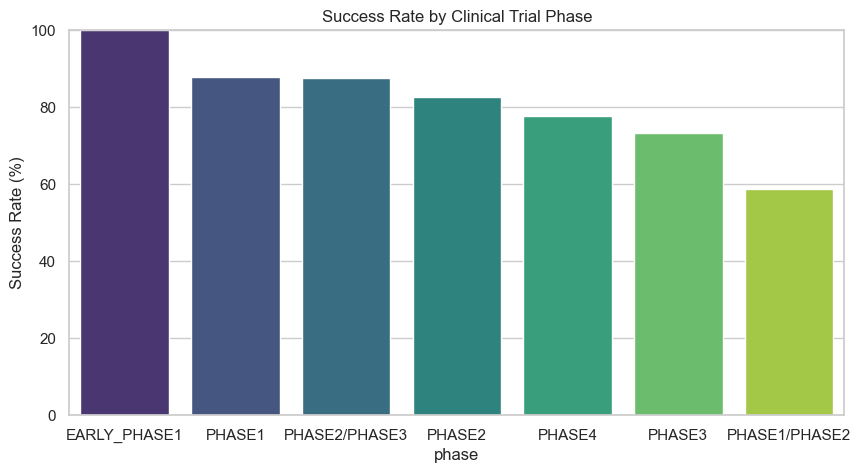

In [7]:
# 1. Calculate Success Rate by Phase
phase_analysis = df_clean.groupby('phase')['target'].mean().reset_index()
phase_analysis['success_rate_pct'] = phase_analysis['target'] * 100

# 2. Sort so the chart looks clean
phase_analysis = phase_analysis.sort_values('success_rate_pct', ascending=False)

print(phase_analysis)

# 3. Plot it
plt.figure(figsize=(10, 5))
sns.barplot(data=phase_analysis, x='phase', y='success_rate_pct', palette='viridis', hue='phase')
plt.title("Success Rate by Clinical Trial Phase")
plt.ylabel("Success Rate (%)")
plt.ylim(0, 100) # Fix y-axis from 0 to 100
plt.show()

sponsor_type
OTHER        456
INDUSTRY     176
OTHER_GOV     20
NIH           13
FED           12
NETWORK        9
Name: count, dtype: int64


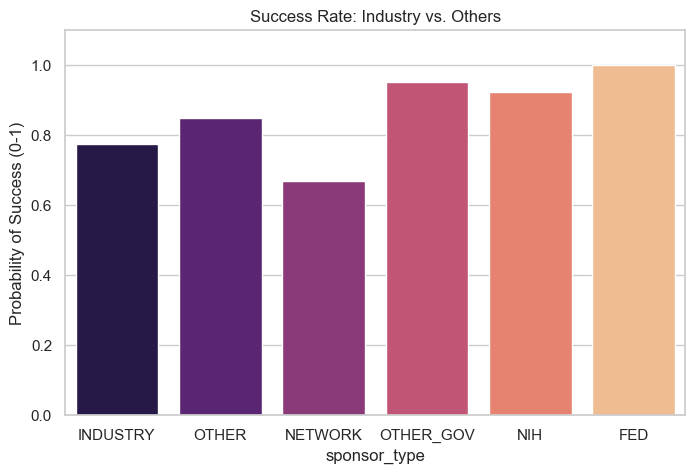

In [8]:
# 1. Check the top sponsor types
print(df_clean['sponsor_type'].value_counts())

# 2. Plot Success Rate by Sponsor Type
plt.figure(figsize=(8, 5))
sns.barplot(data=df_clean, x='sponsor_type', y='target', palette='magma', errorbar=None, hue='sponsor_type')
plt.title("Success Rate: Industry vs. Others")
plt.ylabel("Probability of Success (0-1)")
plt.ylim(0, 1.1)
plt.show()

In [10]:
# Save the clean dataset for the next step (Machine Learning)
clean_file_path = '../data/clinical_trials_clean.csv'
df_clean.to_csv(clean_file_path, index=False)

print(f"Saved clean data to: {clean_file_path}")
print(f"Ready for Machine Learning with {len(df_clean)} trials.")

Saved clean data to: ../data/clinical_trials_clean.csv
Ready for Machine Learning with 686 trials.
